# Aradhya Goswami - Brainwave Task 2

In [6]:
!pip install wordcloud

  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/fa/5f/34a0c0be52dc95f96aa1197f03ad5d5c58a9901c74f050d21a3e1b21ebf9/wordcloud-1.9.4-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.6/167.6 kB 426.0 kB/s eta 0:00:00a 0:00:01


## Import Libraries

In [7]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from collections import Counter

## Download Resources

In [4]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/aradhya814/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aradhya814/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aradhya814/nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/aradhya814/nltk_data...


True

## Load Datasets

In [8]:
# Load datasets
train_df = pd.read_csv("twitter_training.csv")
validation_df = pd.read_csv("twitter_validation.csv")

print("Training Data Loaded. Shape:", train_df.shape)
print("Validation Data Loaded. Shape:", validation_df.shape)


Training Data Loaded. Shape: (74682, 4)
Validation Data Loaded. Shape: (1000, 4)


In [9]:
train_df

,id,topic,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [10]:
validation_df

,id,topic,sentiment,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...
...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


## Explore Datasets

In [11]:
# Explore datasets
def explore_data(df, name):
    print(f"Dataset: {name}")
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    print(df.head())
    print()

explore_data(train_df, "Training Data")
explore_data(validation_df, "Validation Data")


Dataset: Training Data
Shape: (74682, 4)
Columns: ['id', 'topic', 'sentiment', 'text']
     id        topic sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                                text  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  

Dataset: Validation Data
Shape: (1000, 4)
Columns: ['id', 'topic', 'sentiment', 'text']
     id      topic   sentiment  \
0  3364   Facebook  Irrelevant   
1   352     Amazon     Neutral   
2  8312  Microsoft    Negative   
3  4371      CS-GO    Negative   
4  4433     Google     Neutral   

                                                text  
0  I mentioned on Facebook th

## Data Preprocessing

In [13]:
def preprocess_text(text):
    if not isinstance(text, str):  # Check if the input is a string
        return ""  # Return an empty string for non-string values
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@[A-Za-z0-9_]+|#[A-Za-z0-9_]+', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Remove special characters and numbers
    tokens = word_tokenize(text)  # Tokenize
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize
    return ' '.join(tokens)

# Apply preprocessing
train_df['processed_text'] = train_df['text'].apply(preprocess_text)
validation_df['processed_text'] = validation_df['text'].apply(preprocess_text)

In [14]:
# Validate results
print(train_df[['text', 'processed_text']].head())
print(validation_df[['text', 'processed_text']].head())

                                                text  \
0  im getting on borderlands and i will murder yo...   
1  I am coming to the borders and I will kill you...   
2  im getting on borderlands and i will kill you ...   
3  im coming on borderlands and i will murder you...   
4  im getting on borderlands 2 and i will murder ...   

                 processed_text  
0  im getting borderland murder  
1            coming border kill  
2    im getting borderland kill  
3   im coming borderland murder  
4  im getting borderland murder  
                                                text  \
0  I mentioned on Facebook that I was struggling ...   
1  BBC News - Amazon boss Jeff Bezos rejects clai...   
2  @Microsoft Why do I pay for WORD when it funct...   
3  CSGO matchmaking is so full of closet hacking,...   
4  Now the President is slapping Americans in the...   

                                      processed_text  
0  mentioned facebook struggling motivation go ru...  
1  bbc news 

## Visualize Sentiment Distribution

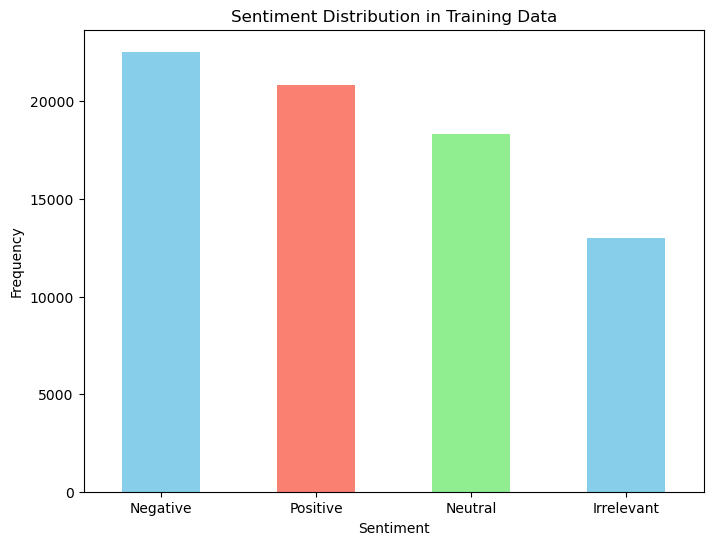

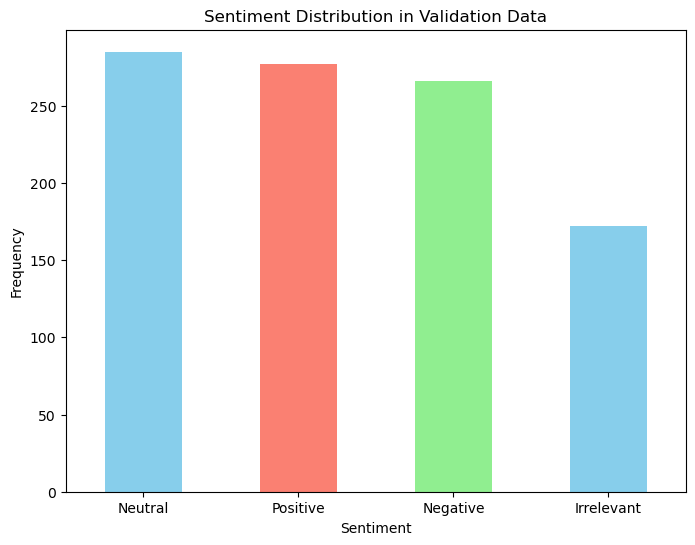

In [15]:
def plot_sentiment_distribution(df, title):
    sentiment_counts = df['sentiment'].value_counts()
    sentiment_counts.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'], figsize=(8, 6))
    plt.title(title)
    plt.xlabel('Sentiment')
    plt.ylabel('Frequency')
    plt.xticks(rotation=0)
    plt.show()

plot_sentiment_distribution(train_df, "Sentiment Distribution in Training Data")
plot_sentiment_distribution(validation_df, "Sentiment Distribution in Validation Data")


## Generate Word Clouds

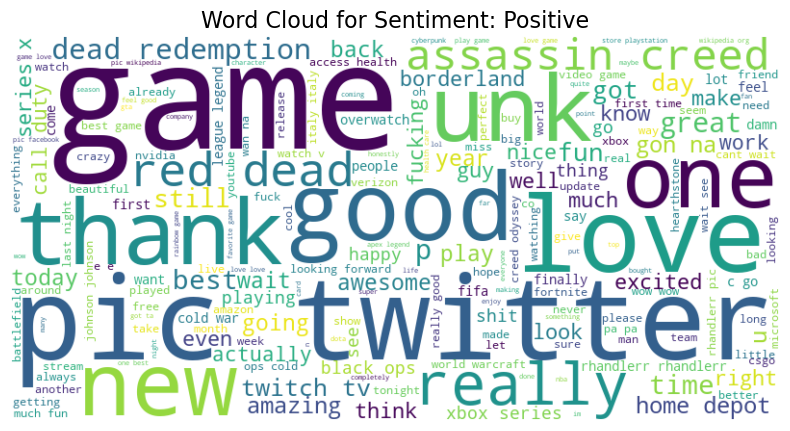

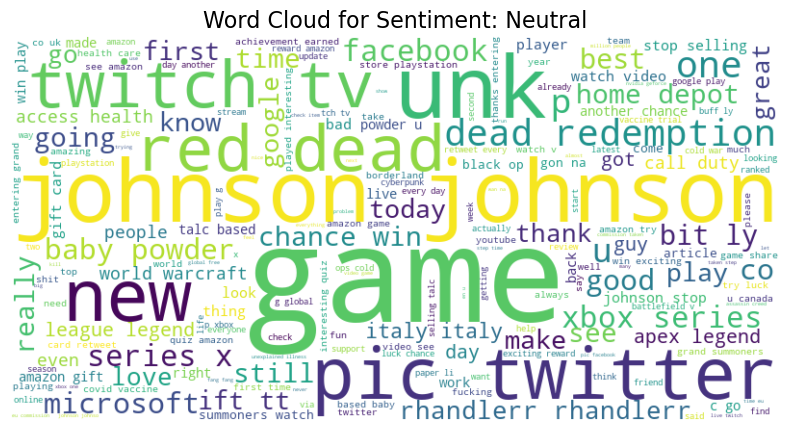

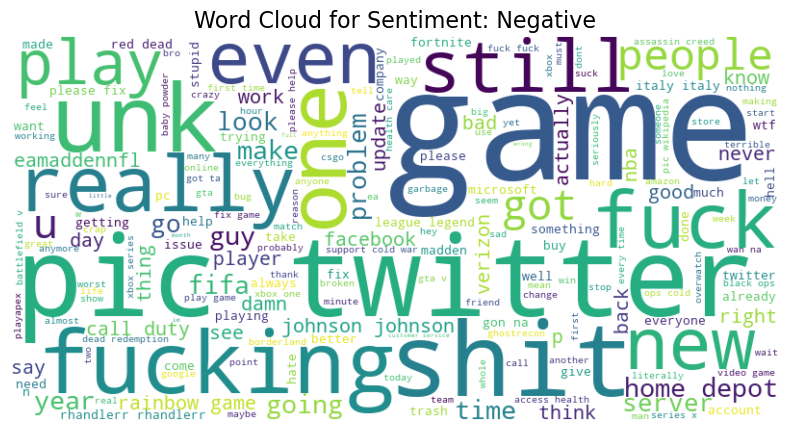

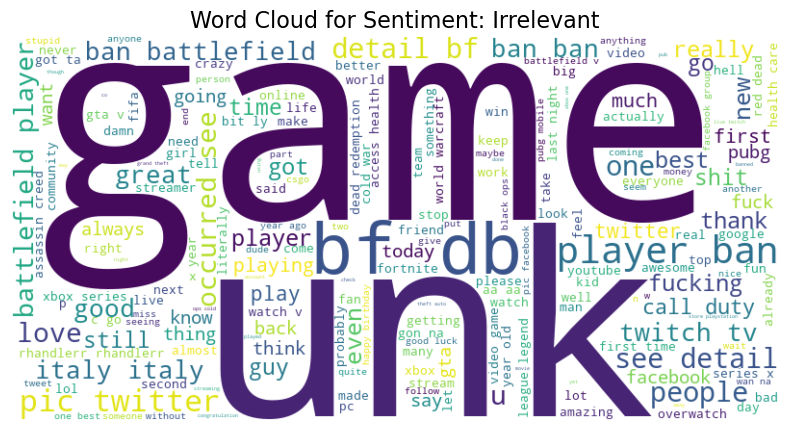

In [16]:
def plot_wordcloud(df, sentiment, title):
    text = ' '.join(df[df['sentiment'] == sentiment]['processed_text'].tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

for sentiment in train_df['sentiment'].unique():
    plot_wordcloud(train_df, sentiment, f"Word Cloud for Sentiment: {sentiment}")


## Feature Extraction with TF-IDF

In [17]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_df['processed_text']).toarray()
X_val = vectorizer.transform(validation_df['processed_text']).toarray()

y_train = train_df['sentiment']
y_val = validation_df['sentiment']


## Train Random Forest Classifier

In [18]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Evaluate Model Performance

In [19]:
y_pred = model.predict(X_val)

print("Classification Report:\n", classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("Accuracy Score:", accuracy_score(y_val, y_pred))

Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.98      0.92      0.95       172
    Negative       0.94      0.97      0.95       266
     Neutral       0.96      0.94      0.95       285
    Positive       0.93      0.96      0.95       277

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000

Confusion Matrix:
 [[159   4   3   6]
 [  0 257   5   4]
 [  0   8 268   9]
 [  3   4   4 266]]
Accuracy Score: 0.95


## Visualize Confusion Matrix

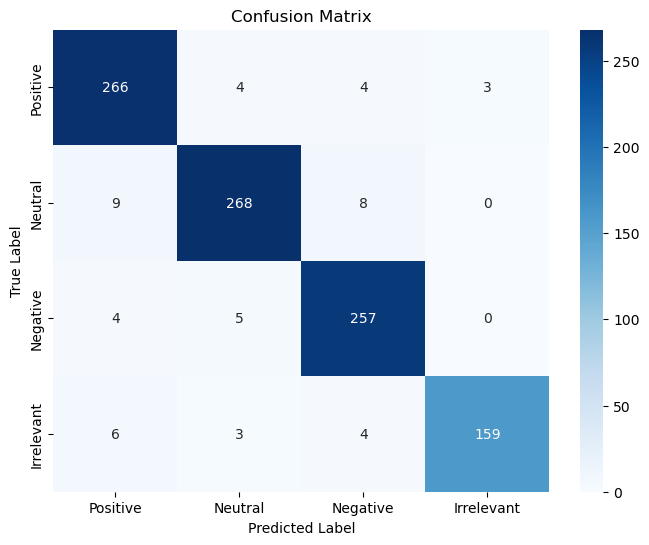

In [21]:
def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

plot_confusion_matrix(y_val, y_pred, labels=train_df['sentiment'].unique(), title="Confusion Matrix")

## Feature Importance

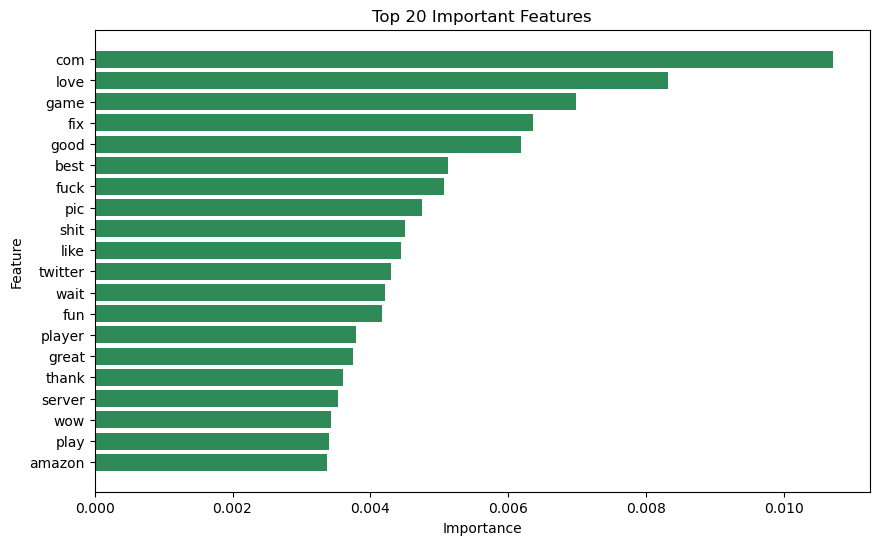

In [22]:
def plot_feature_importance(vectorizer, model, top_n=20):
    feature_importances = model.feature_importances_
    feature_names = vectorizer.get_feature_names_out()
    top_features = np.argsort(feature_importances)[-top_n:]
    
    plt.figure(figsize=(10, 6))
    plt.barh([feature_names[i] for i in top_features], feature_importances[top_features], color='seagreen')
    plt.title(f"Top {top_n} Important Features")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

plot_feature_importance(vectorizer, model, top_n=20)

## Sentiment Trends Over Time

In [28]:
if 'timestamp' in train_df.columns:
    train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
    trend_data = train_df.groupby([train_df['timestamp'].dt.date, 'sentiment']).size().unstack()
    trend_data.plot(kind='line', figsize=(12, 6))
    plt.title("Sentiment Trends in Training Data")
    plt.xlabel("Date")
    plt.ylabel("Count")
    plt.legend(title="Sentiment")
    plt.show()
